# Tutorial 3: Classification using simple statistics
## Part a:  Using thresholds ##

---

### Welcome to the next-to-last tutorial

This tutorial will show you how to use python code to implement and evaluate a classification method applied to a dataset (namely, our rooibos data). Current classification methods can be categorized as either (1) basic statistical methods; (2) machine learning; or (3) deep learning. In this notebook, we will use two classical statistical methods: thresholding and  Mahalanobis distance (a mathematical concept invented by the Indian statistician P.C. Mahalanobis in 1936).

Besides using the classification methods, it is also important to evaluate the performance of each method. In many cases, one of the two classes is of particular interest. In such cases there is a tradeoff between positively identifying all instances of this class, and avoiding positives. This tradeoff is expressed in terms of two important concepts (which are explained below):  _recall_ and _precision_. 

When the two classes are equally important, the overall classification accuracy is often used as a measure of performance. As with any parameter estimation, it is important to put error bars on accuracy estimates. For this purpose, we will introduce the "jackknife" method for estimating standard deviations of estimators.  As its name suggests, the jackknife method is a very useful general-purpose tool which can be applied to a wide variety of estimators.  

---

### Overview of the classification problem  in general

The following picture demonstrates the simple idea behind computational classification of objects. The general procedure is:
* Extract features from data;
* Pass the features into a model;
* The model outputs a determination of the sample's class.

<img src="pics/cat.png" width="700" height="300">

In this tutorial we are classifying tea samples, and the  features we will be using are the TPC, TEAC, and FRAP measurements obtained from chemical assays.

To make this work, the analyst must:
* Determine informative features to be used;
* Develop a model that can effectively make use of the features extracted;
* Evaluate the accuracy of the overall system


### Binary classification errors: false positives and false negatives

Binary classification supposes that we are trying to distinguish between two classes, denoted as "null" and "positive". In this case when distinguishing there are two possible errors: false positive or false negative:
  * **[False positive](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where you receive a positive result for a test, when you should have received a negative (null) result. For example, it occurs when a cancer screening test comes back positive, but you don’t have the disease.
  * **[False negative](https://www.statisticshowto.com/false-positive-definition-and-examples/)**: This is where a negative (null) test result is wrong. For example, in the Justice System, a false negative occurs when a guilty suspect is found “not guilty” and allowed to walk free.
  
Based on these definitions, we may define:

   * _False positive rate_: What proportion of positive identifications were actually negatives?
   * _False negative rate_: What proportion of negative identifications were actually positive?

These two work against each other: decreasing the false positive rate tends to increase the false negative rate.


* False positive rate is related to [specificity  and precision](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)
* False negative rate is related to [recall and sensitivity](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall)

We will define precision and recall below. Of the four measures mentioned, these are the two that are most often used.

### Classification by threshold, and measures of performance

Often binary classification is based on a single feature (or measurement), or a single quantity calculated from the features of the data sample. If this quantity exceeds a threshold (which is set by the programmer) then the sample is judged to be in one class, and if not the sample is put in the other class.

The following [figure](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) shows 30 predictions made by an email classification model. Those to the right of the classification _threshold_ are classified as "spam", while those to the left are classified as "not spam."

<img src="pics/preVSrec.svg" width="700" height="200">

where the results can be summaried as follows:

<img src="pics/table.png" width="300" height="150">


From these we may calculate:

* _Precision_ (specificity) measures the percentage of **emails flagged as spam** that were correctly classified—that is, the proportion of all dots to the right of the threshold line that are green in the above figure.
<img src="pics/pre.png" width="350" height="150">
* _Recall_ (sensitivity)  measures the percentage of **actual spam emails** that were correctly classified—that is, the proportion of all green dots that are to the right of the threshold line in the above figure.
<img src="pics/rec.png" width="330" height="160">
* _Accuracy_ gives the overall percentage of correct classifications, and can be calculated  as follows: <br><br>
<img src="pics/acc.png" width="550" height="270">

Different thresholds will give different values for these three measures. 

---

[**Exercise 1:**](https://developers.google.com/machine-learning/crash-course/classification/check-your-understanding-accuracy-precision-recall) Consider a classification model that separates email into two categories: "spam" or "not spam." If you raise the classification threshold, what will happen to precision? What about recall?


---

### Representing threshold performance tradeoffs  with receiver operating characteristic [(ROC)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) curves

Receiver operating characteristic (ROC) curves are used to determine thresholds based on the trade-off between false positive error and false negative error. The ROC curve actually shows something slightly different--it represents the proportion of negatives that are _incorrectly_ classified on the x axis versus the proportion of positives that are _correctly_ classified on the y-axis. 

Our example will use code the python packages matplotlib, numpy, and sklearn. We will also make use of some pre-written programs that are located in the `source` directory--these will be imported later.



In [1]:
# ___Cell no. 1___

# Python packages 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

Recover data


In [2]:
# ___Cell no. 2___

%store -r df_nf
%store -r df_fer
%store -r df

print("Shape of data frame (rows, columns) is: ", df.shape) 

Shape of data frame (rows, columns) is:  (98, 8)


Now, let's look at the imported data

In [3]:
# ___Cell no. 3___

print(df.head(2))

   type    TPC_MEOH    TEAC_MEOH    FRAP_MEOH  TPC_H2O  TEAC_H2O  FRAP_H2O cut
0     0  275.767474  2821.888864  1180.778887   314.33   2588.61    584.61  FC
1     0  253.494375  2355.706326   647.096605   331.41   2818.87    589.91  LL


---

Now let's create arrays for the inputs and outputs. We will separately identify water-based and methanol-based features.

In [4]:
# ___Cell no. 4___

feat_H2O = ['TPC_H2O', 'TEAC_H2O',  'FRAP_H2O'] # define the input (features) for H20
feat_MEOH = ['TPC_MEOH', 'TEAC_MEOH',  'FRAP_MEOH'] # define the input (features) for MeOH

y = df[['type']] # define the output (target)

We consider the case where we are trying to use individual features to distinguish between fermented and nonfermented.  Since we have three different features, for each feature we can set a classification threshold.  The question is:  of these three features, which will give better classification results? We may use the ROC curves associated with each feature to determine this.

We may draw the ROC curves by sorting the data (together with its classification) and counting:

### Exercise 1
Complete the incomplete portions of the following code according to the comments (marked with a @@@)

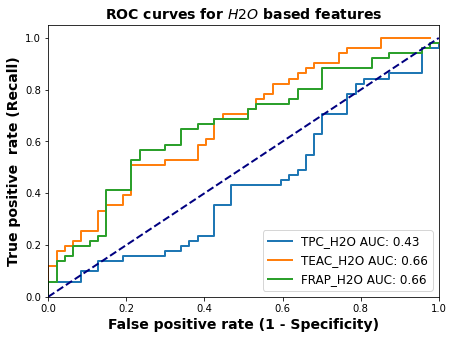

In [5]:
# ___Cell no. 5___

# ROC curves
# True = above threshold is taken as positive, False = above threshold is taken as negative
thrPos =[True,True,True] 
plt.figure(figsize=(7 , 5))
for f, thp in zip(feat_H2O, thrPos):
    xArr = np.array(df[[f]]).flatten()
    nx = len(xArr)
    yArr = np.array(y).flatten()
    # Flip pos/neg labels if negatives are above threshold
    if not(thp):
        yArr = 1-yArr
    # Sort the values in increasing order
    ix = np.argsort(xArr)
    # Sort the corresponding type determination
    ySort= yArr[ix]
    # Running count of number of positives below threshold
    FN = np.cumsum(ySort)
    # Running count of number of negatives below threshold
    TN = np.cumsum(1-ySort)
    # Running count of number of positives above threshold
    TP # =  @@@ Complete this
    # Running count of number of negatives above threshold
    FP # = @@@ Complete this
    # Proportion of positives that are above the threshold
    TPR = TP/(TP+FN)
    # Propostion of negatives that are above the threshold
    FPR # = @@@ Complete this
    # Plot FPR (x-axis) versus TPR (y-axis)
    plt.plot(FPR,TPR, lw=2, label = f+" AUC: "+str(round(metrics.auc(FPR, TPR),2)) )

# Plot 45 degree line ('guessing')    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# Set x and y limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# label x and y axes
plt.xlabel('False positive rate (1 - Specificity)', fontweight ='bold', fontsize =14)
plt.ylabel('True positive  rate (Recall)', fontweight ='bold', fontsize =14)
# title and legend
plt.title('ROC curves for $H2O$ based features', fontweight ='bold', fontsize =14)
plt.legend(loc="lower right", prop={"size":12})
plt.show() 




Each line in the above graph shows the true positive and false positive rates for classifiers based on a threshold applied to a single feature.  The $x$ and $y$ values depend on the threshold that is set (the thresholds themselves not shown in the graph--only the rates are shown).  For example, if we use the `TPC_H2O` feature and set the threshold  so that the false positive rate is 0.3 (i.e. the specificity is 1- 0.3 = 0.7), then the true positive rate (recall) is between 0.4 and 0.5. 

The dotted line (which has a slope of 1) corresponds to random guessing:  if you simply make random guesses, then the true and false positive rates will be equal.  A good classifier will have points with large true positive rates and small false positive rate. In other words, the ROC cuve should be *above* the 45 degree line, and the higher the better. The AUC (area under curve) is an overall measure of how high above the 45 degree line the curve is. An AUC value of 0.5 is equivalent to random guessing, while an AUC value of 1 indicates perfect classification (which of courses is rarely possible in practice).  

We can see that some classifiers give an AUC value of less than 0.5.  This means that these classifiers are *worse* than random guessing.  How to solve this problem? Easy--we just reinterpret the threshold so that values _below_ the threshold are classified as positive, and the rest negative.  We can do this in the code by specifying the option `False` for the value of `thrPos` for the corresponding curve. 

---
**Exercise 2:** Copy and change the above code so that all ROC curves lie above the dotted line.
<br>


In [6]:
#  ___ code here ____



---
**Exercise 3:** Make another graph for the three features based on MeOH. Make sure that all curves are above the dotted line.
<br>


In [7]:
#  ___ code here ____



The ROC curve does not actually tell you which threshold to use. Rather, it only tells you what true positive/false positive tradeoffs are possible.  The user will have to decide which tradeoff is most suitable for his situation, and set the threshold accordingly. 

ROC curves are especially useful if you want to compare different classifiers. Classifiers with higher ROC curves are better than classifiers with lower curves.


---
**Exercise 4:** Use the AUC's obtained frm ROC curves to determine which of the 6 individual measurements gives the best classifier.

### Classification using multiple thresholds

Suppose now that you want to distinguish fermented and unfermented samples based one two variables. One way to do this is set a threshold for each variable, and classify each sample based on the size of the two variables relative to the threshold. For example, if you use `TP_MEOH` and `TEAC_MEOH` and the threshold values are 350 for `TPC_MEOH` and 2250 for `TEAC_MEOH`, then the two thresholds divide the plane into four quadrants, and we can classify each sample as fermented or unfermented depending on which quadrant it lies in.


**Exercise 5**

This is a long exercise with many parts! You may create additional code and text cells as needed for your answers.


a. Make a copy of the plot that you constructed in Exercise 2 in Tutorial 2. Using the threshold values 350 for `TPC_MEOH` and 2250 for `TEAC_MEOH`, draw the four quadrants produced by the two thresholds. Which sample type would be best to assign to each quadrant?

b. We may investigate which pair of thresholds will give the best performance.  Write a program that does the following: 

  - Loop through 50 evenly-spaced thresholds for TPC and 50 evenly-spaced thresholds for TEAC
  - For each of the 2500 threshold pair, compute the accuracy of a classifier based on that pair of thresholds
  - Store your accuracies in a $50 \times 50$ matrix
  - Do a contour plot that displays accuracy as a function of the two thresholds. Do also a heatmap  that displays the same information. Decide which of the two is most informative, and justify your decision (you can write your justification as a comment at the beginning of the program.
   - Locate a pair of thresholds that gives the best accuracy. On the plot that you choose, draw the two thresholds as horizontal and vertical lines.
   - Superimpose the two sets of data points on your plot (scatter plot).
   - Your program should also output the accuracy obtained by the best pair of thresholds
   
c. Modify your program from (b) to calculate the _precision_ and _recall_. You may look up the definitions of precision and recall on Wikipedia, which has a very good article on this. Basically, precision tells you what proportion of your positive identifications are actually positive, while recall tells you what proportion of all true positives are identified as positive.

Redo the contour plot (or heatmap) to show the precision, and also a separate plot to show the recall.

d. On the basis of (c) above, explain why precision and recall alone are insufficient to determine a best estimator.

e. There is an alternative criterion to evaluate estimators called the _F-score_ (Wikipedia also has a good article on this). The F-score combines precision and recall. Do another contour plot (or heatmap) to show the F-score for threshold pairs. Include in your plot two lines that indicate the best pair of thresholds.


f. When the two classes have similar sizes, the F-score and the accuracy are nearly the same. However,when the class sizes are different, the results may differ somewhat.

Modify your dataset by randomly removing half of the fermented data points, and repeat the contour plots (or heatmaps) for accuracy and for F score. Comment on how the best thresholds for accuracy and the best thresholds for F-score have changed as a result of the changed datasets. Which of the two (accuracy or F-score) is more robust (i.e. changes less) due to the changed dataset? Can you explain why?

g. The Machine Learning Crash Course offered by Google demonstrates feature crosses in this 'Playground' exercise: https://developers.google.com/machine-learning/crash-course/feature-crosses/playground-exercises. Based on this and the graphs you have produced, what feature crosses would you use to give an accurate classifier that can distinguish fermented from unfermented?  Justify your answer.

h.  If you used feature crosses, would you expect better or worse results than those obtained by a pair of thresholds? Justify your answer.

In [8]:
# ___Cell no. 6___


**Exercise 6** 


Altogether we have 3 estimators for two different types of solvents. Thus we have 3 pairs of water-based estimators, and 3 pairs of methanol-based estimators. 

Create a $3 \times 2$ grid of plots (using the `subplot` command from matplotlib), where the first column of plots shows the 3 water-based pairs and the second column shows the 3 methanol-based pairs. Each plot is a contour plot (or heatmap) for F score like the one in 3e. above. Each subplot should have its own axis labels and title.

In order to keep your code from exploding in size, you should create a function whose inputs are two columns of data, which produces the plot corresponding to those two features. You will then call this function 6 times to produce the 6 subplots.   

Your code should also output the 6 F-scores. If possible figure out a way to highlight the plot within the grid of plots that gives the best F-score  (maybe by changing the color of the plot border? Or by changing the title?)

In [9]:
# ___Cell no. 7___



**Exercise 7** _(Challenge)_

a. Create a function that takes 3 columns of data and produces the best set of three thresholds to distinguish the 3 corresponding features ('best' in the sense that it produces the best accuracy). The inputs two your functions should include the data columns, the data label, and a list of 3 numbers that gives the number of thresholds tried in each of the three directions. Your function should return the three thresholds that give the best results, and  the corresponding accuracy value. 
_
The three thresholds will divide the entire data region into 8 subregions. Since it is not clear which subregion should be assigned to which category, You should try all different assignments. This means there are $2^8=64$ possible subregion assignment.  Since this is going to take a lot of computation, you shouldn't try too many thresholds.  When you are developing your code, you may use 5 thresholds for each features.

b.  Use your function to find the best set of three features among the 6 features. Note there are $6!/(3! 3!) = 20 possibilities, so you will need to call your function in a loop.

c. Does including th third feature improve the prediction very much? Explain your answer. 